**PUNCTUL 0 - Instalare dependințe**

In [2]:
!pip install pyspark==3.5.1 --quiet
print("PySpark instalat")

PySpark instalat


In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
    .master("local[*]")
    .appName("30k")
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.40.0")
    .config("parentProject", "my-project-007-473913")
    .getOrCreate())
print("Spark pornit")

Spark pornit


In [4]:
from google.colab import auth
auth.authenticate_user()
print("Autentificat în GCP")

Autentificat în GCP


**PUNCTUL 1 - Selectarea unui dataset de tip BigData din Google Cloud Platform GCP**

Dataset-ul GitHub Repos (bigquery-public-data.github_repos.sample_contents), cu peste 2.8 milioane de înregistrări de fișiere din repo-uri GitHub, este perfect pentru a analiza tendințe în programare, limbaje populare sau colaborare în software development. Datele sunt semi-structurate (conțin și câmpuri JSON-like), ceea ce oferă flexibilitate pentru query-uri complexe și prelucrare ulterioară, inclusiv export în CSV.

Am încărcat 30.000 de linii din BigQuery folosind Spark + connector-ul oficial Google.  
Tabelul se numește "my_github_analysis.github_sample_contents_30k" și conține:  
- "id", "size", "content", "binary", "copies" , sample_path", "sample_repo_name", "sample_ref", "sample_mode", "sample_symlink_target"


In [27]:
# Încărcare tabel
df = spark.read.format("bigquery") \
    .option("table", "my_github_analysis.github_sample_contents_30k") \
    .option("project", "my-project-007-473913") \
    .load()
print("Tabel încărcat")

Tabel încărcat


In [26]:
# Afișare 5 linii din tabel
df.show(5, False)

+----------------------------------------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Contorizare linii tabel
df.cache()
print(f"Sunt {df.count():,} de linii de date!")

Sunt 30,000 de linii de date!


**PUNCTUL 2 – Prelucrarea dataset-ului utilizand PySpark in mediul Google Colab, in vederea extragerii de statistici descriptive si identificarii unor insight-uri semnificative**



Această analiză utilizează 11 măsurători și vizualizări distincte cu scopul este de a evalua structura internă (numărul, mărimea și tipul fișierelor) și distribuția resurselor pentru a identifica anomaliile și a facilita strategiile de optimizare a datelor.

In [29]:
# Setul minimal de importuri

# 1. Pentru PySpark Dataframe (Manipulare date și SQL-like)
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum, count, regexp_extract

# 2. Pentru Conversia la Pandas și Operații Text Avansate
import pandas as pd
from collections import Counter
import re
from itertools import chain

# 3. Pentru Vizualizare (Grafice)
import matplotlib.pyplot as plt
import seaborn as sns

**Analiza 1: top n extensii**

Arată ce tipuri de fișiere (extensii) sunt folosite cel mai des (ex: .js, .py, .md).

--- 1. top 50 extensii (grafic bar) ---
arată ce tipuri de fișiere (extensii) sunt folosite cel mai des (ex: .js, .py, .md).


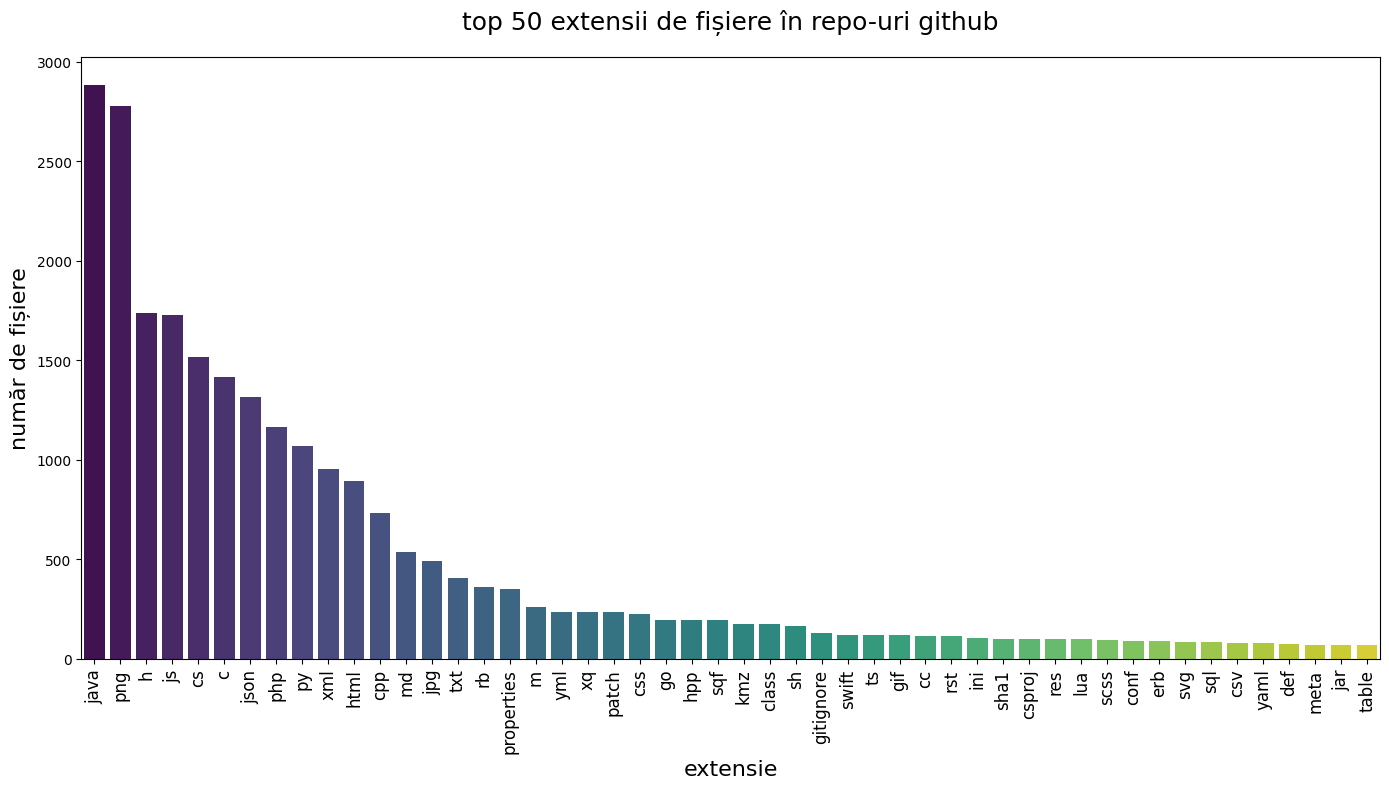

In [50]:
# analiza 1: top n extensii (grafic bar)
n_top_extensii = 50
print(f"--- 1. top {n_top_extensii} extensii (grafic bar) ---")
print ("arată ce tipuri de fișiere (extensii) sunt folosite cel mai des (ex: .js, .py, .md).")

# extrage extensia (pyspark)
df_ext = df.withColumn(
    'extensie',
    F.regexp_extract(col('sample_path'), r'\.(\w+)$', 1) # CORECTAT: folosit F în loc de f
).filter(col('extensie') != '')

# calculează top n și convertește la pandas pentru grafic
top_ext_pd = df_ext.groupBy('extensie').count().orderBy(col('count').desc()).limit(n_top_extensii).toPandas()
#print(f"\ntop {n_top_extensii} extensii:\n{top_ext_pd}")

# grafic bar
plt.figure(figsize=(14, 8))
sns.barplot(x='extensie', y='count', data=top_ext_pd, hue='extensie', palette='viridis', legend=False)
plt.title(f'top {n_top_extensii} extensii de fișiere în repo-uri github', fontsize=18, pad=20)
plt.xlabel('extensie', fontsize=16)
plt.ylabel('număr de fișiere', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

Această analiză vizualizează distribuția frecvenței absolute pentru primele $N$ extensii de fișiere. dominanța anumitor extensii (e.g., limbaje de programare majore, fișiere de configurare sau de documentare) indică tendințele prevalente în dezvoltarea software-ului open-source și alocarea resurselor în funcție de tipul de fișier.

**Analiza 2: top n repo-uri**


Arată care sunt repo-urile care au cel mai mare număr de fișiere.

--- 2. top 50 repo-uri (grafic bar) ---

top 50 repo-uri:
                                    sample_repo_name  count
0                                  Akkadius/EQEmuEOC   1317
1   540co/dod-president-budget-procurement-rdte-data   1001
2                         Alfresco/community-edition    976
3                                       28msec/zorba    576
4       AcademicTorrents/AcademicTorrents-Downloader    461
5                                     Alfresco/Aikau    405
6                     AdrianApostolov/TelerikAcademy    389
7                                     ASMlover/study    368
8    Adobe-Marketing-Cloud/aem-commerce-omni-channel    358
9                                        52North/SOS    297
10                            APE-Project/APE_Server    285
11                              0x1mason/GribApi.NET    267
12                                       Abjad/abjad    261
13                                   AbiWord/abiword    256
14                                 APCVSRe

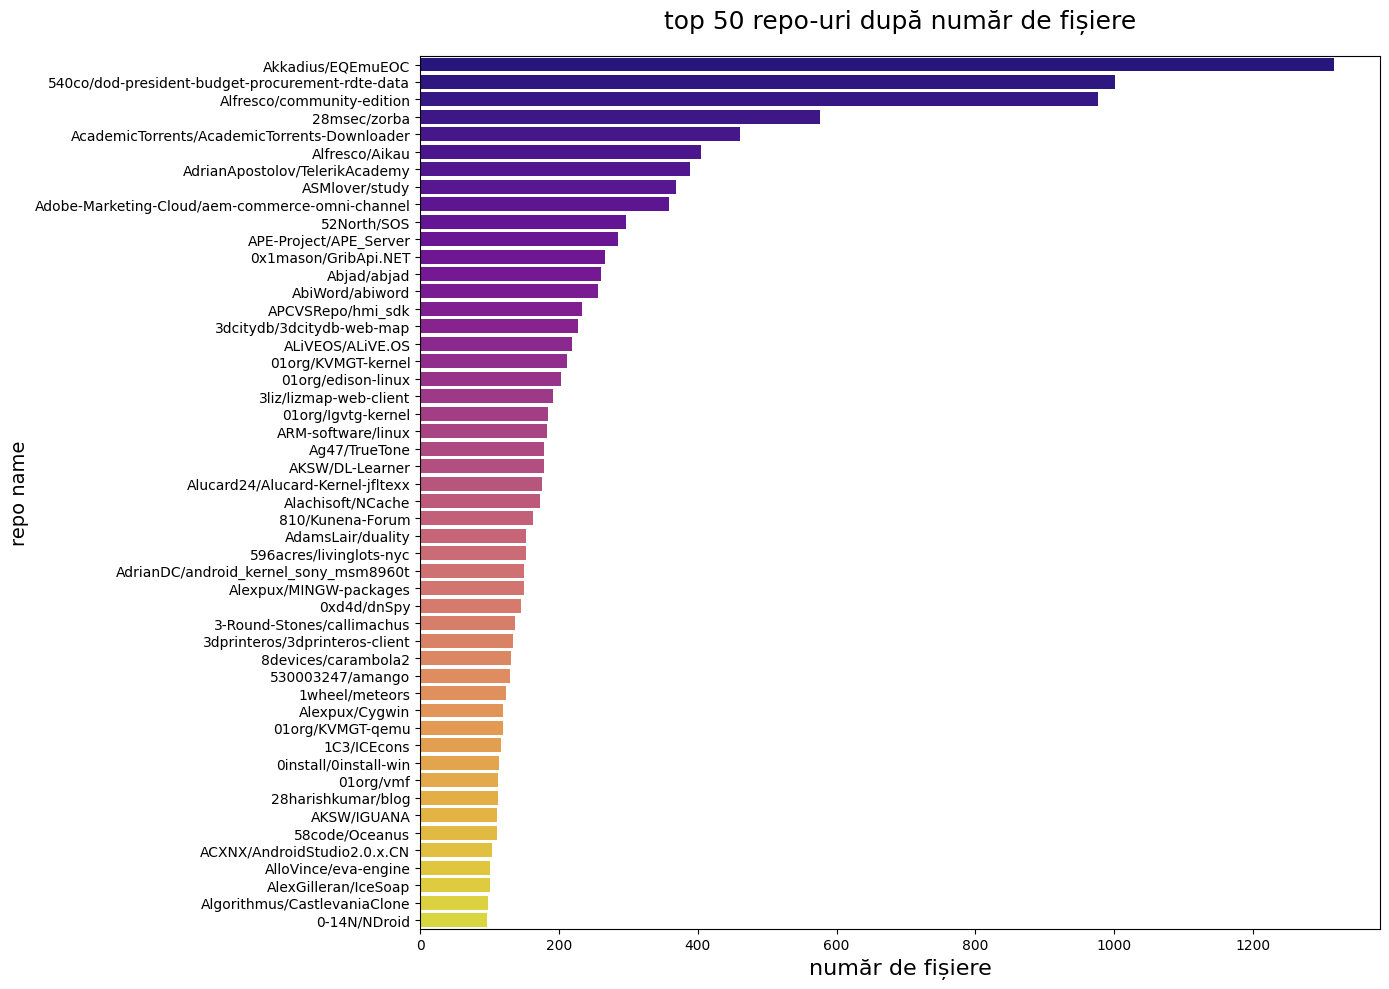

In [36]:
# analiza 2: top n repo-uri (grafic bar)
n_top_repo = 50
print(f"--- 2. top {n_top_repo} repo-uri (grafic bar) ---")

# calculează top n și convertește la pandas pentru grafic
top_repos_pd = df.groupBy('sample_repo_name').count().orderBy(col('count').desc()).limit(n_top_repo).toPandas()
print(f"\ntop {n_top_repo} repo-uri:\n{top_repos_pd}")

# grafic bar
plt.figure(figsize=(14, 10))
sns.barplot(x='count', y='sample_repo_name', data=top_repos_pd, hue='sample_repo_name', palette='plasma', legend=False)
plt.title(f'top {n_top_repo} repo-uri după număr de fișiere', fontsize=18, pad=20)
plt.xlabel('număr de fișiere', fontsize=16)
plt.ylabel('repo name', fontsize=14)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Analiza ierarhizează cele mai mari $N$ repo-uri pe baza numărului total de fișiere conținute. această metrică servește ca proxy pentru complexitatea sau dimensiunea proiectului și identifică entitățile cu cea mai mare amprentă structurală în setul de date.

**Analiza 3: dimensiune medie pe extensie (top n)**

Arată care sunt extensiile de fișiere care au în medie cea mai mare dimensiune (în bytes).

--- 3. dimensiune medie (bytes) pe extensie (top 50) ---

dimensiune medie (bytes) pe extensie (top 50 frecvente):
      extensie      mean_size
0          csv  953964.345679
1          jar  386759.086957
2          gif  350990.033898
3          xml  245145.400419
4          sqf  147413.698980
5         json   96260.524279
6          jpg   63915.271429
7          png   54775.885488
8          txt   52100.118227
9         yaml   36292.101266
10         yml   28044.118143
11           c   26117.230389
12         css   22356.792035
13         svg   20250.620690
14         res   20192.370000
15         cpp   18881.087432
16         def   17741.739726
17          js   14848.710892
18         sql   11405.686047
19         ini   10912.226415
20           h    6588.754023
21        java    6427.180493
22         lua    6408.040404
23          cc    6394.179487
24          py    6107.914714
25       patch    5985.141631
26        html    5821.800000
27           m    5639.814672
28         php 

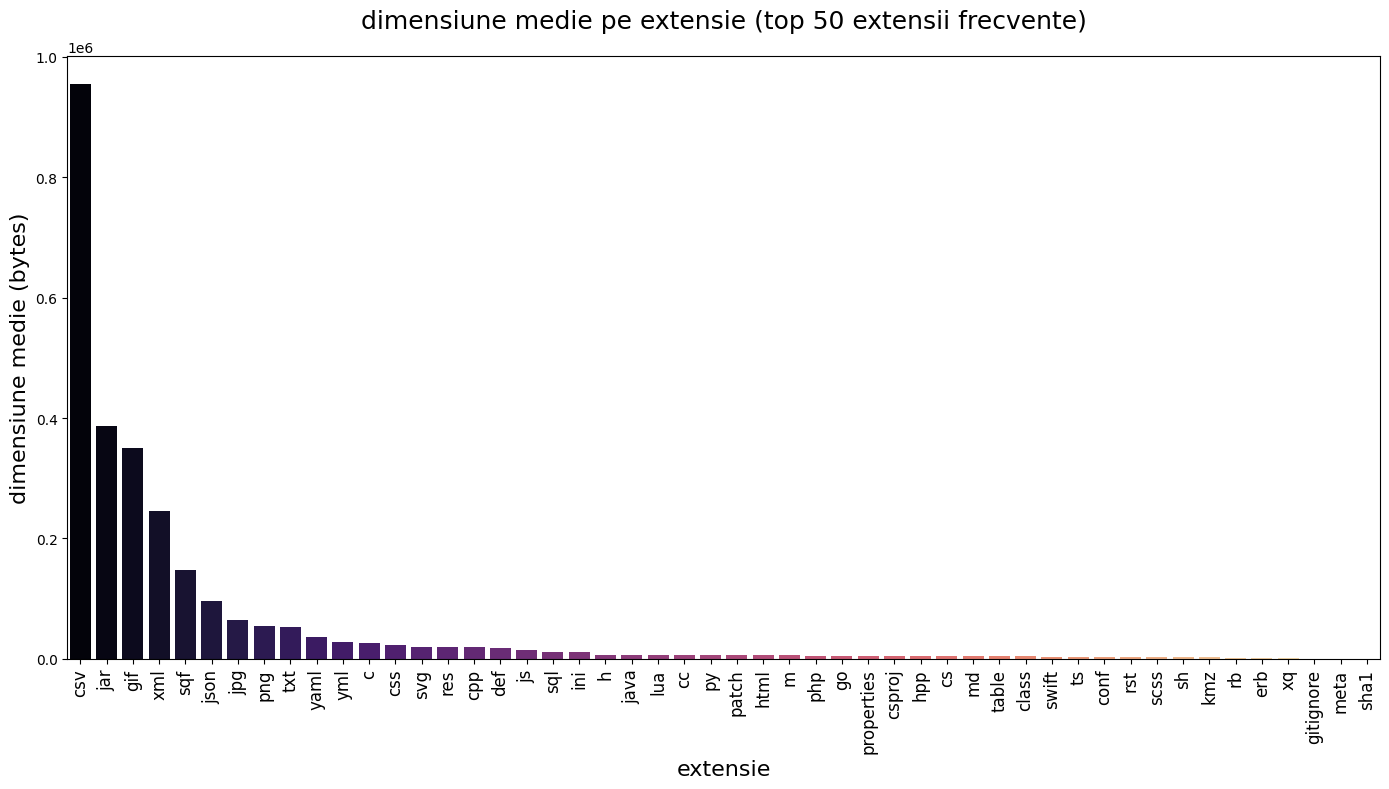

In [38]:
# analiza 3: dimensiune medie pe extensie (top n)
n_medie_extensii = 50
print(f"--- 3. dimensiune medie (bytes) pe extensie (top {n_medie_extensii}) ---")

# extrage extensia (pyspark)
df_ext_size = df.withColumn(
    'extensie',
    F.regexp_extract(col('sample_path'), r'\.(\w+)$', 1) # CORECTAT: folosit F în loc de f
).filter(col('extensie') != '')

# găsește top n extensii frecvente (pentru filtrare)
top_ext_list = [row['extensie'] for row in df_ext_size.groupBy('extensie').count().orderBy(col('count').desc()).limit(n_medie_extensii).collect()]

# calculează dimensiunea medie pe extensiile filtrate
size_by_ext_pd = df_ext_size.filter(col('extensie').isin(top_ext_list)) \
    .groupBy('extensie') \
    .agg(F.avg('size').alias('mean_size')) \
    .orderBy(col('mean_size').desc()) \
    .toPandas()

print(f"\ndimensiune medie (bytes) pe extensie (top {n_medie_extensii} frecvente):\n{size_by_ext_pd}")

# grafic bar
plt.figure(figsize=(14, 8))
sns.barplot(x='extensie', y='mean_size', data=size_by_ext_pd, hue='extensie', palette='magma', legend=False)
plt.title(f'dimensiune medie pe extensie (top {n_medie_extensii} extensii frecvente)', fontsize=18, pad=20)
plt.xlabel('extensie', fontsize=16)
plt.ylabel('dimensiune medie (bytes)', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

Se calculează media aritmetică a dimensiunii fișierelor (în bytes) pentru cele mai frecvente $N$ extensii. Identificarea extensiilor cu o dimensiune medie ridicată (e.g., .bin, .jar, imagini) este crucială pentru estimarea costurilor de stocare și optimizarea performanței la clonarea sau descărcarea proiectelor.

**Analiza 4: distribuție text vs. binare**

Arată proporția dintre fișierele care conțin text (cod sursă, documente) și cele binare (imagini, executabile).

--- 4. distribuție fișiere text vs binare (grafic pie) ---

distribuție fișiere text vs binare:
binary
binare (true)     4764
text (false)     25236
Name: count, dtype: int64


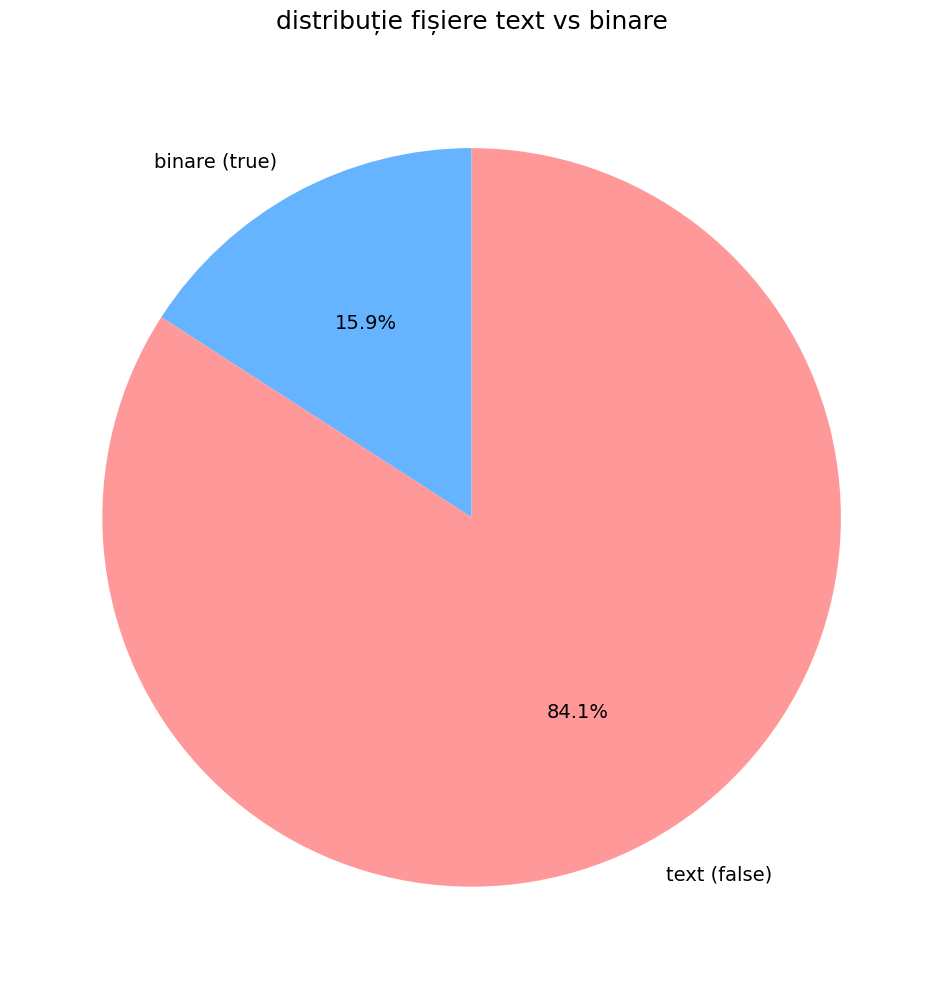

In [39]:
# analiza 4: distribuție text vs. binare (grafic pie)
print("--- 4. distribuție fișiere text vs binare (grafic pie) ---")

# calculează distribuția și convertește la pandas
text_vs_binary_pd = df.groupBy('binary').count().toPandas()
text_vs_binary_pd['binary'] = text_vs_binary_pd['binary'].apply(lambda x: 'binare (true)' if x else 'text (false)')
text_vs_binary_pd = text_vs_binary_pd.set_index('binary')['count']

print(f"\ndistribuție fișiere text vs binare:\n{text_vs_binary_pd}")

# grafic pie
plt.figure(figsize=(10, 10))
plt.pie(text_vs_binary_pd.values, labels=text_vs_binary_pd.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90, textprops={'fontsize': 14})
plt.title('distribuție fișiere text vs binare', fontsize=18, pad=20)
plt.tight_layout()
plt.show()

Graficul circular ilustrează raportul procentual dintre fișierele clasificate ca text (cod sursă, mark-up, documente) și cele binare (executabile, media, arhive). Acest raport este fundamental pentru înțelegerea naturii și a utilizării predominante a datelor din repo-uri (concentrare pe cod vs. pe resurse).

**Analiza 5: extensii vs. dimensiune medie**

Combină popularitatea unei extensii cu dimensiunea medie a fișierelor sale, arătând dacă fișierele comune sunt mari sau mici.

--- 5. extensii vs dimensiune medie (scatter plot, top 50) ---


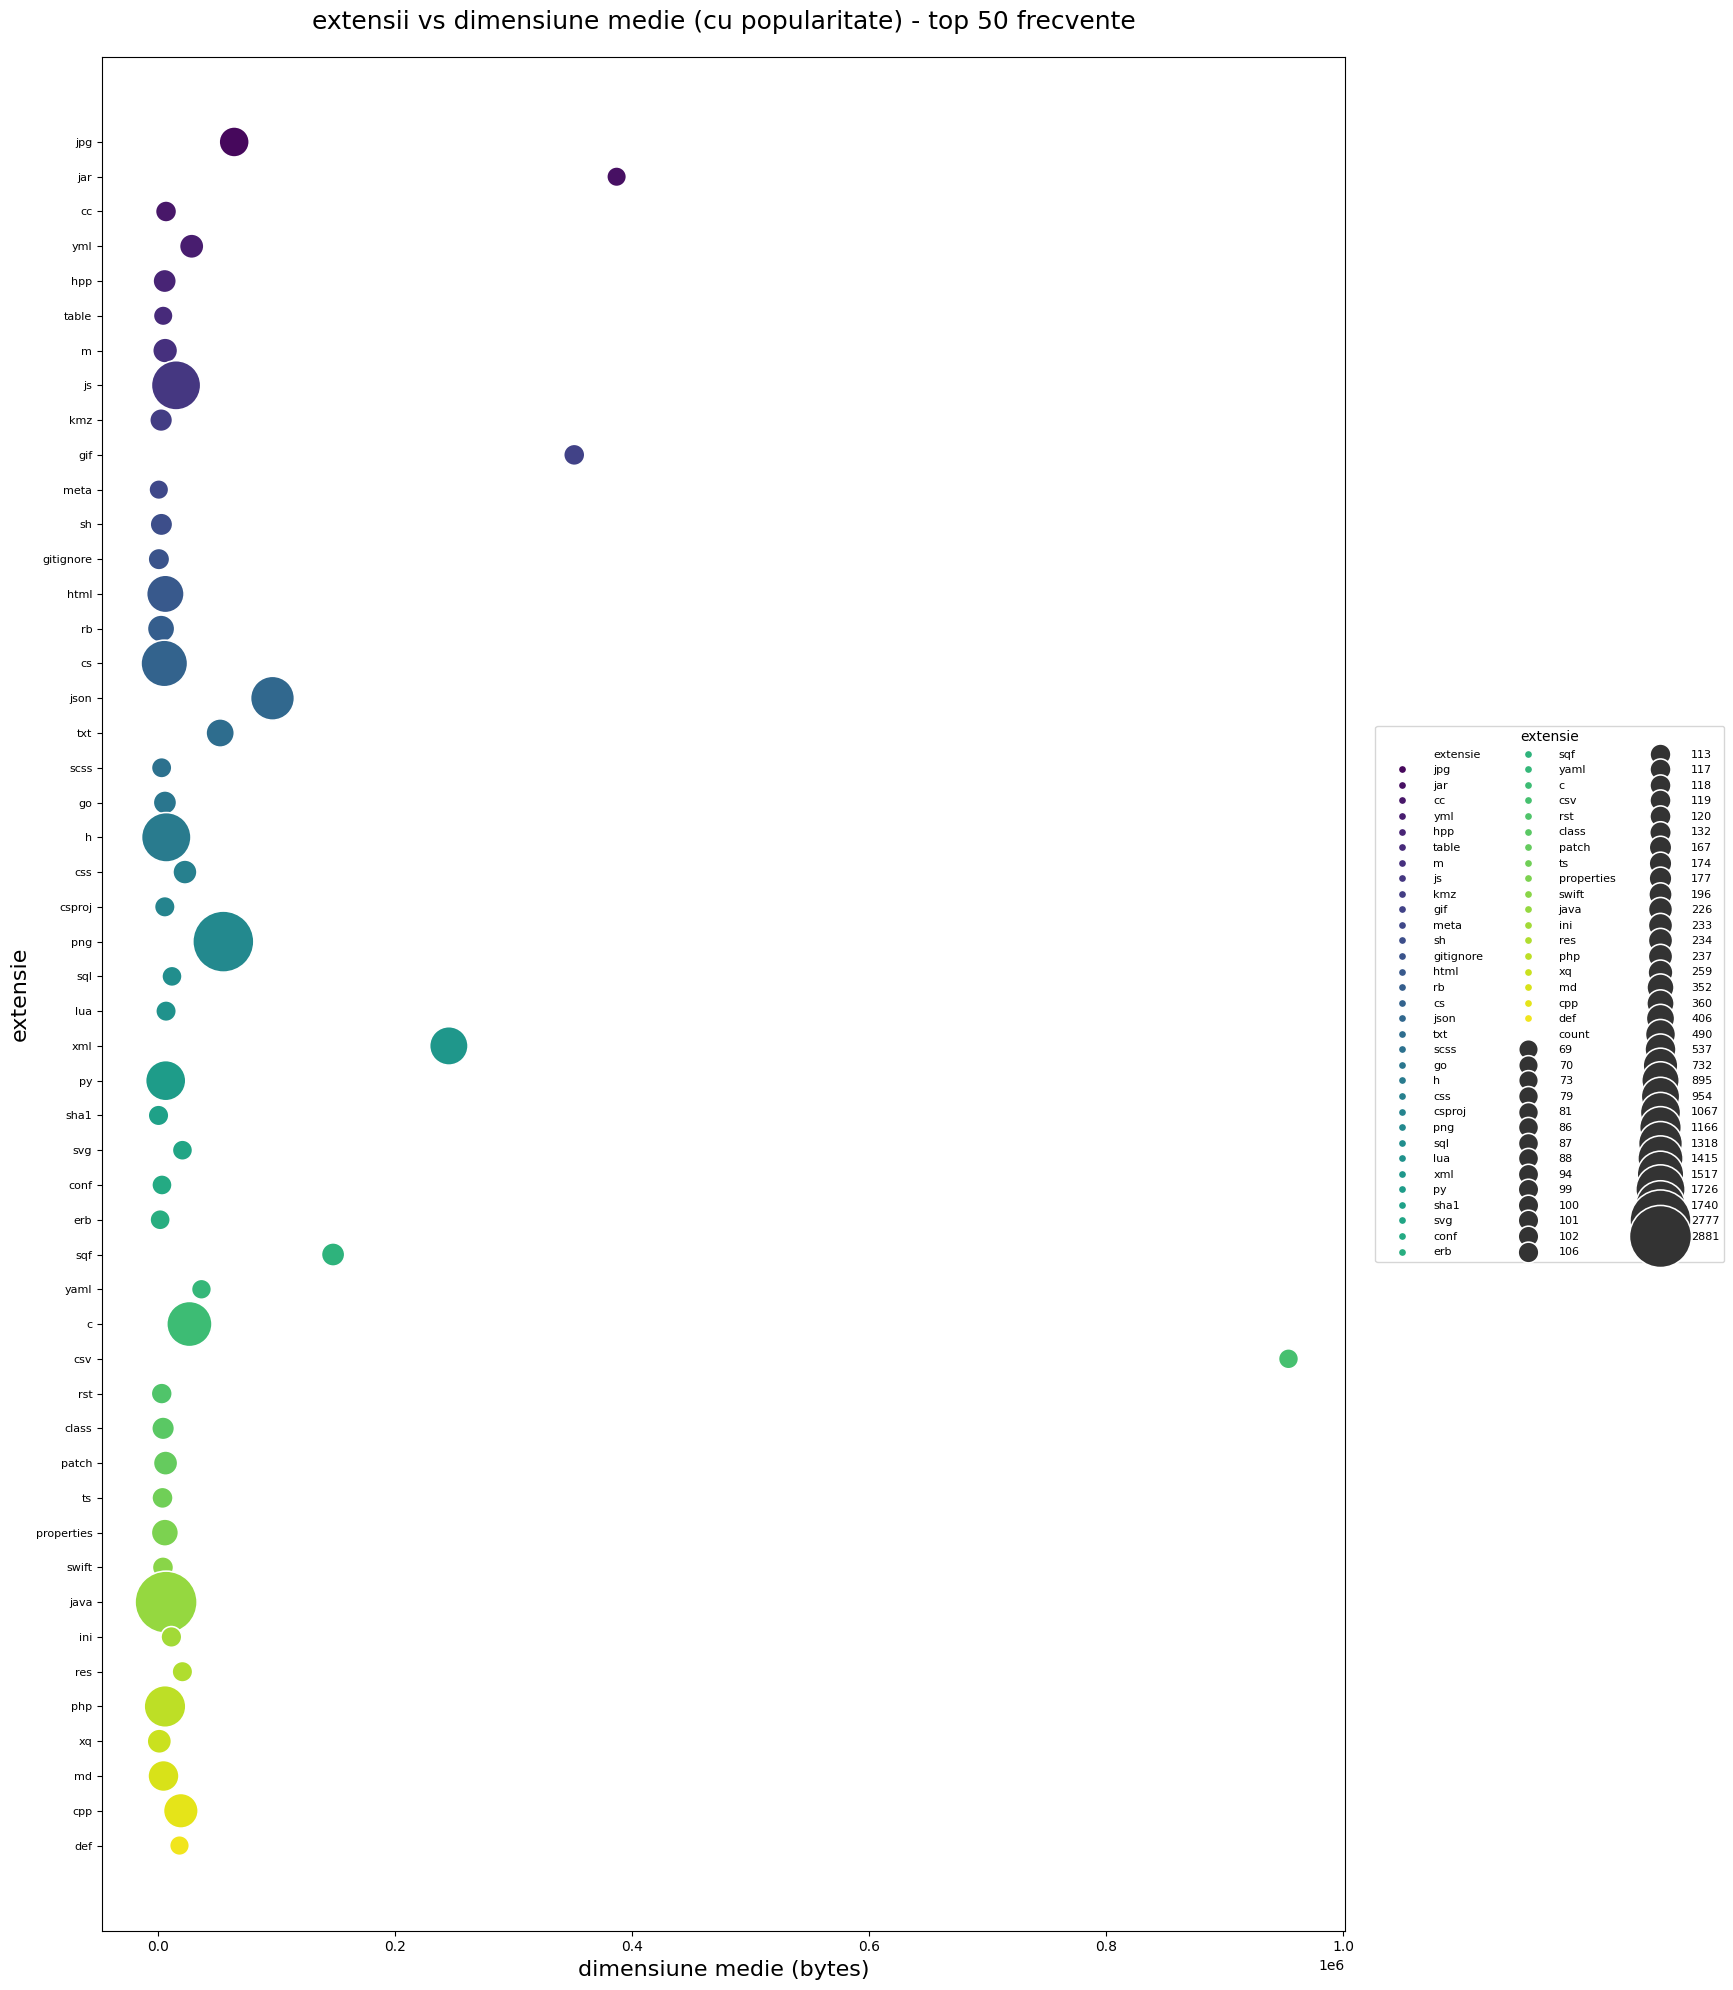

In [40]:
# analiza 5: extensii vs. dimensiune medie (scatter plot)
n_scatter_plot = 50
print(f"--- 5. extensii vs dimensiune medie (scatter plot, top {n_scatter_plot}) ---")

# extrage extensia
df_ext_scatter = df.withColumn('extensie', F.regexp_extract(col('sample_path'), r'\.(\w+)$', 1)).filter(col('extensie') != '') # CORECTAT: folosit F în loc de f

# găsește top n extensii frecvente
top_ext_count = df_ext_scatter.groupBy('extensie').count().orderBy(col('count').desc()).limit(n_scatter_plot).collect()
top_ext_list = [row['extensie'] for row in top_ext_count]

# calculează media și count-ul pentru extensiile filtrate
df_grouped_scatter = df_ext_scatter.filter(col('extensie').isin(top_ext_list)) \
    .groupBy('extensie') \
    .agg(F.avg('size').alias('mean_size'), F.count('extensie').alias('count')) \
    .toPandas()

# ajustări de font și legendă
font_size_y = 8
font_size_legend = 8
n_cols_legend = 3
right_adjust = 0.75
fig_height = 20 if n_scatter_plot > 30 else 12

# grafic
plt.figure(figsize=(18, fig_height))
sns.scatterplot(x='mean_size', y='extensie', size='count', hue='extensie', data=df_grouped_scatter, palette='viridis', sizes=(200, 2000), legend='full')
plt.title(f'extensii vs dimensiune medie (cu popularitate) - top {n_scatter_plot} frecvente', fontsize=18, pad=20)
plt.xlabel('dimensiune medie (bytes)', fontsize=16)
plt.ylabel('extensie', fontsize=16)
plt.yticks(fontsize=font_size_y)
plt.legend(title='extensie', loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=font_size_legend, frameon=True, ncol=n_cols_legend, handlelength=4)
plt.tight_layout()
plt.subplots_adjust(right=right_adjust)
plt.show()

Diagrama scatter compară dimensiunea medie a fișierelor cu frecvența lor (popularitatea) pentru primele $N$ extensii. Dimensiunea punctului (bulă) reprezintă numărul total de fișiere, oferind o viziune tridimensională asupra corelației dintre volum, mărimea medie și frecvență.

**Analiza 6: corelație dimensiune vs. număr fișiere (pe repo)**

Arată dacă repo-urile care au multe fișiere sunt și cele care au dimensiunea totală cea mai mare.

--- 6. corelație dimensiune vs număr fișiere pe repo ---


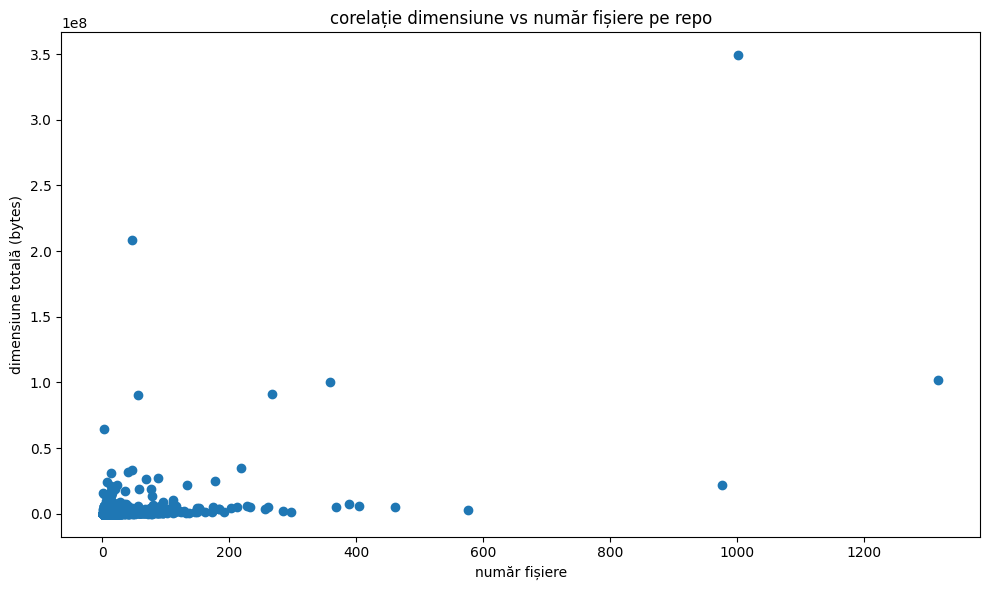

In [41]:
# analiza 6: corelație dimensiune vs. număr fișiere (pe repo)
print("--- 6. corelație dimensiune vs număr fișiere pe repo ---")

# calculează suma dimensiunii și count-ul pe repo (pyspark)
repo_stats_pd = df.groupBy('sample_repo_name') \
    .agg(F.sum('size').alias('total_size'), F.count('*').alias('file_count')) \
    .toPandas()

# grafic
plt.figure(figsize=(10, 6))
plt.scatter(repo_stats_pd['file_count'], repo_stats_pd['total_size'])
plt.title('corelație dimensiune vs număr fișiere pe repo')
plt.xlabel('număr fișiere')
plt.ylabel('dimensiune totală (bytes)')
plt.tight_layout()
plt.show()

Acest grafic explorează corelația dintre numărul total de fișiere și dimensiunea totală (agregată) a datelor per repository. O corelație pozitivă puternică sugerează o creștere liniară a volumului de date odată cu complexitatea structurală (numărul de fișiere).

**Analiza 7: distribuție dimensiuni pe extensie**

Afișează variația de dimensiune în interiorul fiecărui tip de fișier, ajutând la identificarea valorilor extreme (outliers).

--- 7. distribuție dimensiuni pe extensii (boxplot, top 50) ---


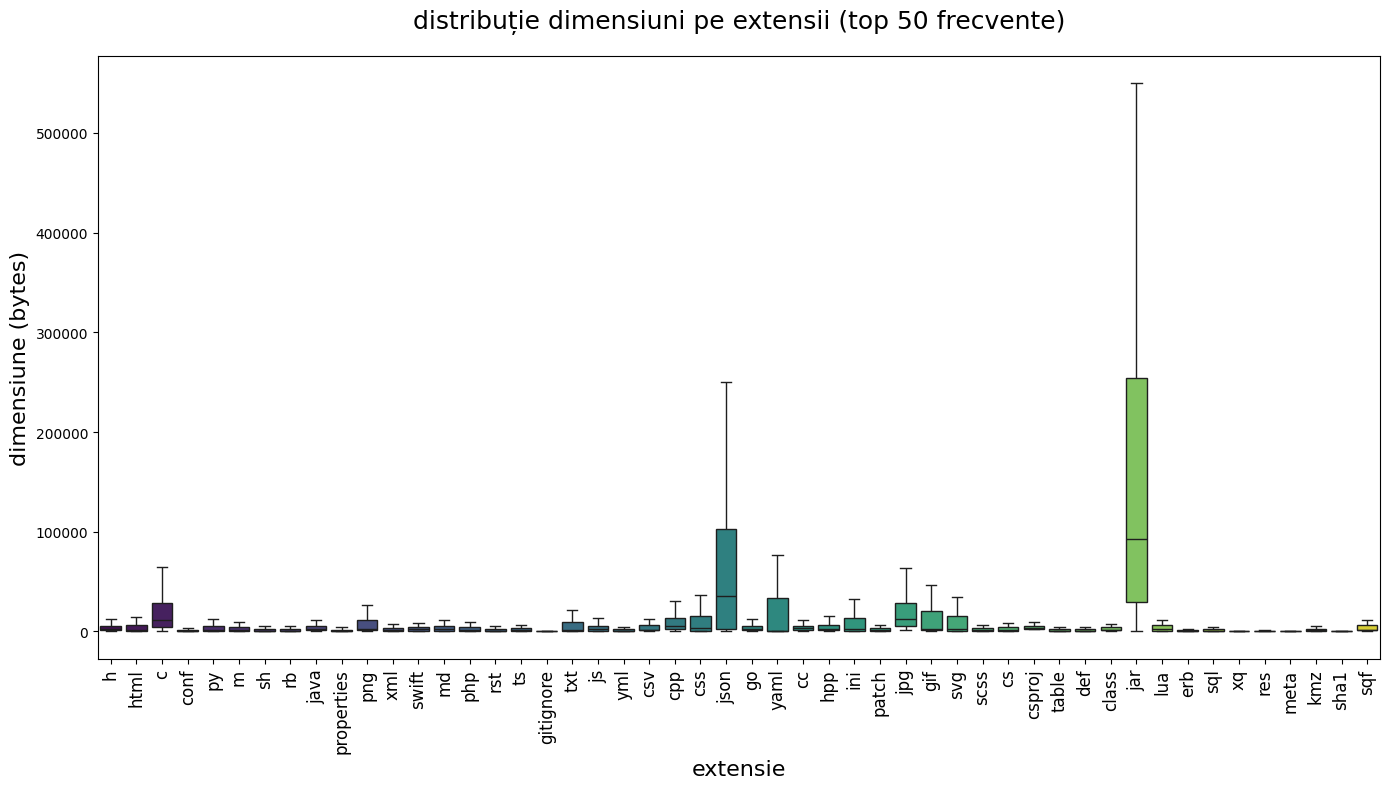

In [43]:
# analiza 7: distribuție dimensiuni pe extensie (boxplot)
n_box_plot_ext = 50
print(f"--- 7. distribuție dimensiuni pe extensii (boxplot, top {n_box_plot_ext}) ---")

# extrage extensia
df_ext_box = df.withColumn('extensie', F.regexp_extract(col('sample_path'), r'\.(\w+)$', 1)).filter(col('extensie') != '')

# găsește top n extensii frecvente
top_ext_list_box = [row['extensie'] for row in df_ext_box.groupBy('extensie').count().orderBy(col('count').desc()).limit(n_box_plot_ext).collect()]

# filtrează dataframe-ul pyspark și convertește la pandas
df_filtered_box = df_ext_box.filter(col('extensie').isin(top_ext_list_box)).select('extensie', 'size').toPandas()

# grafic boxplot (showfliers=false pentru citire mai ușoară)
plt.figure(figsize=(14, 8))
sns.boxplot(x='extensie', y='size', data=df_filtered_box, hue='extensie', palette='viridis', showfliers=False, legend=False)
plt.title(f'distribuție dimensiuni pe extensii (top {n_box_plot_ext} frecvente)', fontsize=18, pad=20)
plt.xlabel('extensie', fontsize=16)
plt.ylabel('dimensiune (bytes)', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

Boxplot-ul vizualizează distribuția mărimii fișierelor pentru cele mai frecvente $N$ extensii. Această analiză este esențială pentru a înțelege dispersia dimensiunilor (iqr) și prezența anomaliilor (outliers) în funcție de tipul de fișier, indicând potențiale fișiere foarte mari în anumite categorii.

**Analiza 8: analiza duplicatelor (copies)**

Identifică repo-urile care au cel mai mare număr de copii ale aceluiași fișier (duplicarea datelor). Dacă un fișier identic este găsit în mai multe locuri în setul nostru de date, acel fișier este considerat o copie. Sumăm toate aceste copii pentru a vedea ce repo-uri contribuie cel mai mult la repetiția (sau duplicarea) datelor.

--- 8. analiza duplicatelor (copii) pe repo (top 50) ---

top 50 repo-uri cu cele mai multe copii:
sample_repo_name
ARM-software/linux                               578866
Alucard24/Alucard-Kernel-jfltexx                 378039
01org/edison-linux                               230824
Altaf-Mahdi/android_kernel_oneplus_msm8994       186714
AdrianDC/android_kernel_sony_msm8960t            169387
01org/Igvtg-kernel                               156524
01org/KVMGT-kernel                                85610
28harishkumar/blog                                58535
Akkadius/EQEmuEOC                                 26407
8devices/carambola2                               20253
596acres/livinglots-nyc                           15127
01org/KVMGT-qemu                                  14176
AdrianApostolov/TelerikAcademy                    13868
AltraMayor/XIA-for-Linux                          12330
Alexpux/Cygwin                                    11038
3dcitydb/3dcitydb-web-map                   

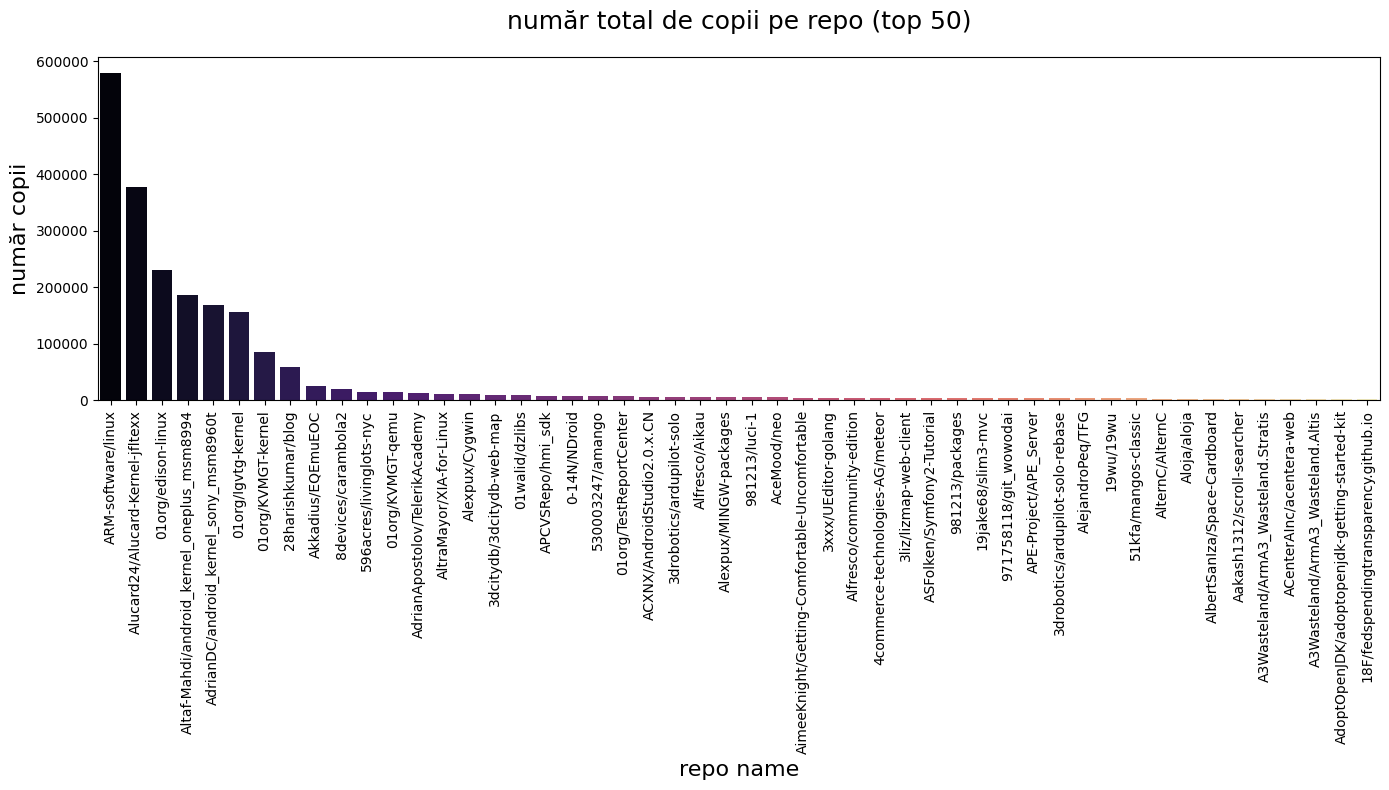

In [44]:
# analiza 8: analiza duplicatelor (copies)
n_top_copii = 50
print(f"--- 8. analiza duplicatelor (copii) pe repo (top {n_top_copii}) ---")

# calculează suma coloanei 'copies' pe repo
copy_stats_pd = df.groupBy('sample_repo_name').agg(F.sum('copies').alias('total_copies')).orderBy(col('total_copies').desc()).limit(n_top_copii).toPandas()
copy_stats_pd = copy_stats_pd.set_index('sample_repo_name')['total_copies']

print(f"\ntop {n_top_copii} repo-uri cu cele mai multe copii:\n{copy_stats_pd}")

# grafic bar
plt.figure(figsize=(14, 8))
sns.barplot(x=copy_stats_pd.index, y=copy_stats_pd.values, hue=copy_stats_pd.index, palette='magma', legend=False)
plt.title(f'număr total de copii pe repo (top {n_top_copii})', fontsize=18, pad=20)
plt.xlabel('repo name', fontsize=16)
plt.ylabel('număr copii', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

Analiza cuantifică total_copies – suma totală a copiilor (duplicatelor) identificate de valoarea din coloana copies (care indică de câte ori un anumit fișier, identificat printr-un hash unic, apare și în alte locații) – agregată pe fiecare depozit (repository). Această metrică de duplicare a datelor (sau repetiție) identifică depozitele care generează cea mai mare volum de repetiție a conținutului în întregul set de date. Acest lucru este esențial pentru dezvoltarea strategiilor de eliminare a duplicatelor (deduplicare) și optimizarea spațiului de stocare.

**Analiza 9: analiza conținutului (top cuvinte)**

Găsește care sunt cele mai des folosite cuvinte în conținutul fișierelor text (cod, documente) și permite căutarea frecvenței unui cuvânt specific definit de utilizator.

--- 9. analiza conținutului (top cuvinte) ---
top 100 cuvinte în conținut (cuvânt: frecvență):
if: 34465
the: 26533
struct: 21211
return: 19962
int: 19239
x: 16004
define: 13247
static: 12827
to: 12672
void: 9766
for: 9397
a: 8870
of: 8646
is: 8269
i: 7565
null: 7399
u: 7365
ret: 7326
in: 6166
unsigned: 5862
this: 5776
case: 5732
and: 5723
include: 5438
else: 5240
err: 4872
break: 4548
const: 4290
be: 4246
goto: 4161
s: 3948
it: 3617
uintt: 3535
or: 3454
we: 3391
not: 3281
char: 3250
data: 3145
long: 3024
dev: 2947
on: 2900
that: 2783
device: 2729
with: 2674
r: 2423
by: 2413
from: 2397
out: 2381
flags: 2358
status: 2352
error: 2333
endif: 2313
size: 2309
val: 2307
as: 2306
type: 2242
c: 2140
len: 2099
name: 2094
value: 2061
are: 2023
public: 1970
software: 1853
d: 1806
an: 1801
p: 1777
skb: 1761
file: 1751
set: 1736
will: 1731
any: 1729
license: 1689
inline: 1683
xf: 1653
can: 1643
addr: 1642
true: 1637
xc: 1628
n: 1626
bit: 1606
all: 1594
offset: 1558
env: 1508
reg: 1505
use: 1502
fun

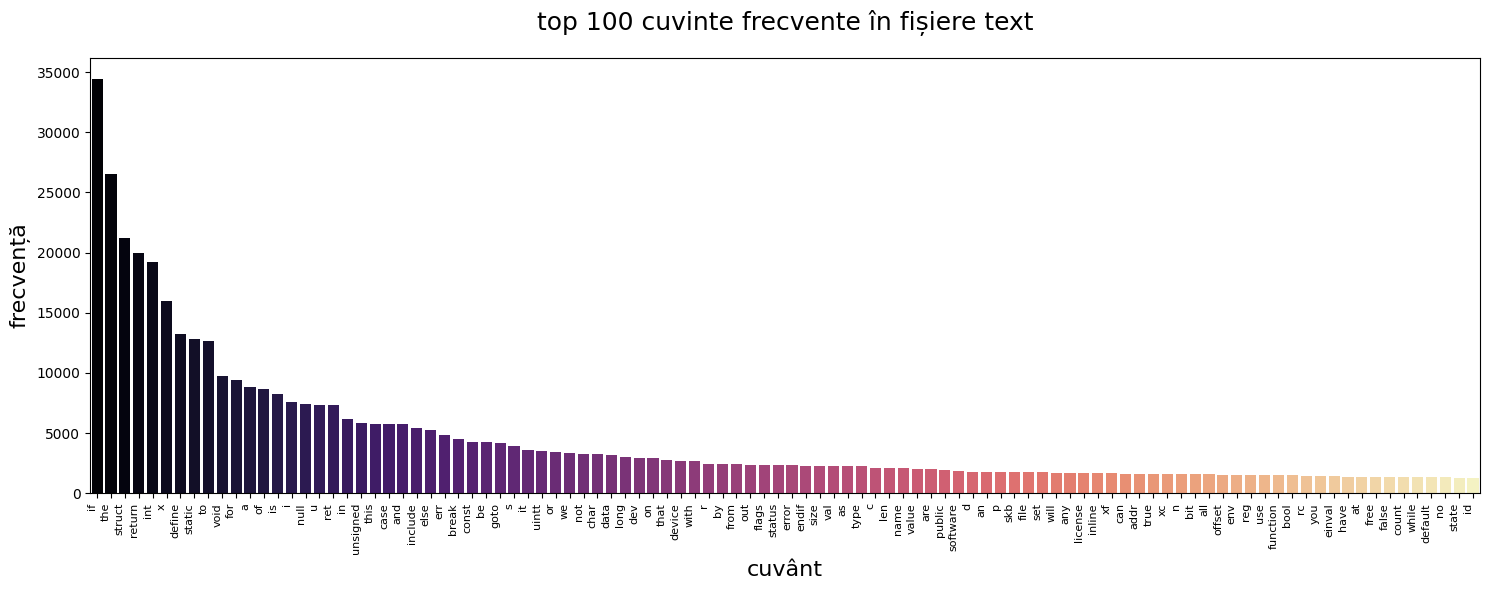

--------------------------------------------------
frecvența cuvântului 'python' în primele 1000 fișiere text este: 10
--------------------------------------------------


In [51]:
# analiza 9: analiza conținutului (top cuvinte)
print("--- 9. analiza conținutului (top cuvinte) ---")

cuvant_cautat = 'python' # modifică această variabilă cu cuvântul dorit (ex. 'test', 'java', 'function')

# funcție pentru a curăța cuvintele
def clean_word(word):
    return re.sub(r'[^a-z]+', '', word)

# setează numărul de fișiere și top cuvinte
num_files = 1000  # caută în primele x fișiere
top_n_words = 100

# filtrează conținutul text și convertește la pandas (doar primele x rânduri)
text_content_pd = df.filter(col('binary') == False) \
    .select('content') \
    .filter(col('content').isNotNull()) \
    .limit(num_files) \
    .toPandas()['content']

# procesare cuvinte (pandas)
words = [clean_word(word) for word in chain.from_iterable(text_content_pd.str.lower().str.split()) if clean_word(word)]
word_counts = Counter(words).most_common(top_n_words)
word_counts_df = pd.DataFrame(word_counts, columns=['word', 'count'])

print(f"top {top_n_words} cuvinte în conținut (cuvânt: frecvență):")
# AFISARE: unul sub altul
for word, count in word_counts:
    print(f"{word}: {count}")

# grafic
plt.figure(figsize=(15, 6))
sns.barplot(x='word', y='count', data=word_counts_df, hue='word', palette='magma', legend=False)
plt.title(f'top {top_n_words} cuvinte frecvente în fișiere text', fontsize=18, pad=20)
plt.xlabel('cuvânt', fontsize=16)
plt.ylabel('frecvență', fontsize=16)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

# căutarea cuvântului definit de variabila 'cuvant_cautat'
clean_search = clean_word(cuvant_cautat.lower())
freq = words.count(clean_search)
print("-" * 50)
if freq > 0:
    print(f"frecvența cuvântului '{cuvant_cautat}' în primele {num_files} fișiere text este: {freq}")
else:
    print(f"cuvântul '{cuvant_cautat}' nu a fost găsit în primele {num_files} fișiere text.")
print("-" * 50)

Această analiză de prelucrare a limbajului natural (nlp) extrage și vizualizează frecvența celor mai frecvente $N$ cuvinte (token-uri, după normalizare) din conținutul fișierelor text. În plus, funcționalitatea de căutare punctuală permite determinarea frecvenței absolute a unui cuvânt specific (cuvant_cautat) în eșantionul analizat, oferind o perspectivă suplimentară asupra utilizării terminologiei cheie în setul de date.

**Analiza 10: adâncimea fișierelor în repo**

Arată cât de adânc sunt fișierele plasate în structura de foldere a repo-urilor (de la directorul rădăcină).

--- 10. distribuție fișiere pe adâncime în repo ---


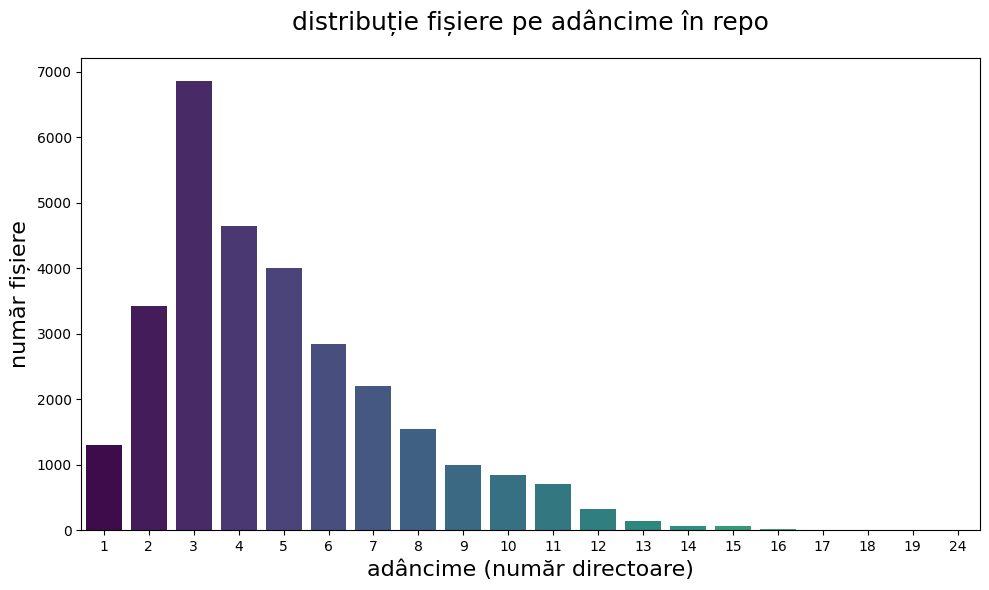

In [52]:
# analiza 10: adâncimea fișierelor în repo
print("--- 10. distribuție fișiere pe adâncime în repo ---")

# calculează adâncimea (pyspark)
df_depth = df.withColumn('depth', F.length('sample_path') - F.length(F.regexp_replace('sample_path', '/', '')) + 1)
depth_counts_pd = df_depth.groupBy('depth').count().orderBy('depth').toPandas()

# grafic
plt.figure(figsize=(10, 6))
sns.barplot(x='depth', y='count', data=depth_counts_pd, hue='depth', palette='viridis', legend=False)
plt.title('distribuție fișiere pe adâncime în repo', fontsize=18, pad=20)
plt.xlabel('adâncime (număr directoare)', fontsize=16)
plt.ylabel('număr fișiere', fontsize=16)
plt.tight_layout()
plt.show()

Această analiză de prelucrare a limbajului natural (nlp) extrage cele mai frecvente $N$ cuvinte (token-uri, după normalizare) din conținutul fișierelor text. frecvența cuvintelor cheie oferă o înțelegere semantică a subiectelor și tehnologiilor dominante din setul de date.

**Analiza 11: dimensiunea totală pe repo**

Arată care sunt repo-urile care ocupă cel mai mult spațiu total pe disc.

--- 11. dimensiunea totală pe repo (top 50) ---

top 50 repo-uri după dimensiune totală (bytes):
sample_repo_name
540co/dod-president-budget-procurement-rdte-data         349144879
AKSW/AutoSPARQL                                          208144066
Akkadius/EQEmuEOC                                        101483064
Adobe-Marketing-Cloud/aem-commerce-omni-channel          100145927
0x1mason/GribApi.NET                                      91491295
39M/LMix                                                  90224025
AlJohri/DAT-DC-12                                         64489422
ALiVEOS/ALiVE.OS                                          34768433
AlexPoint/OpenNlp                                         32976362
AKSW/FOX                                                  31405015
AlessandroDelSole/CodeSnippetStudio                       31035264
0ADMods/millenniumad                                      27109857
50k-Customs/Wheels-Pack                                   26650605
AKSW/DL-Learner

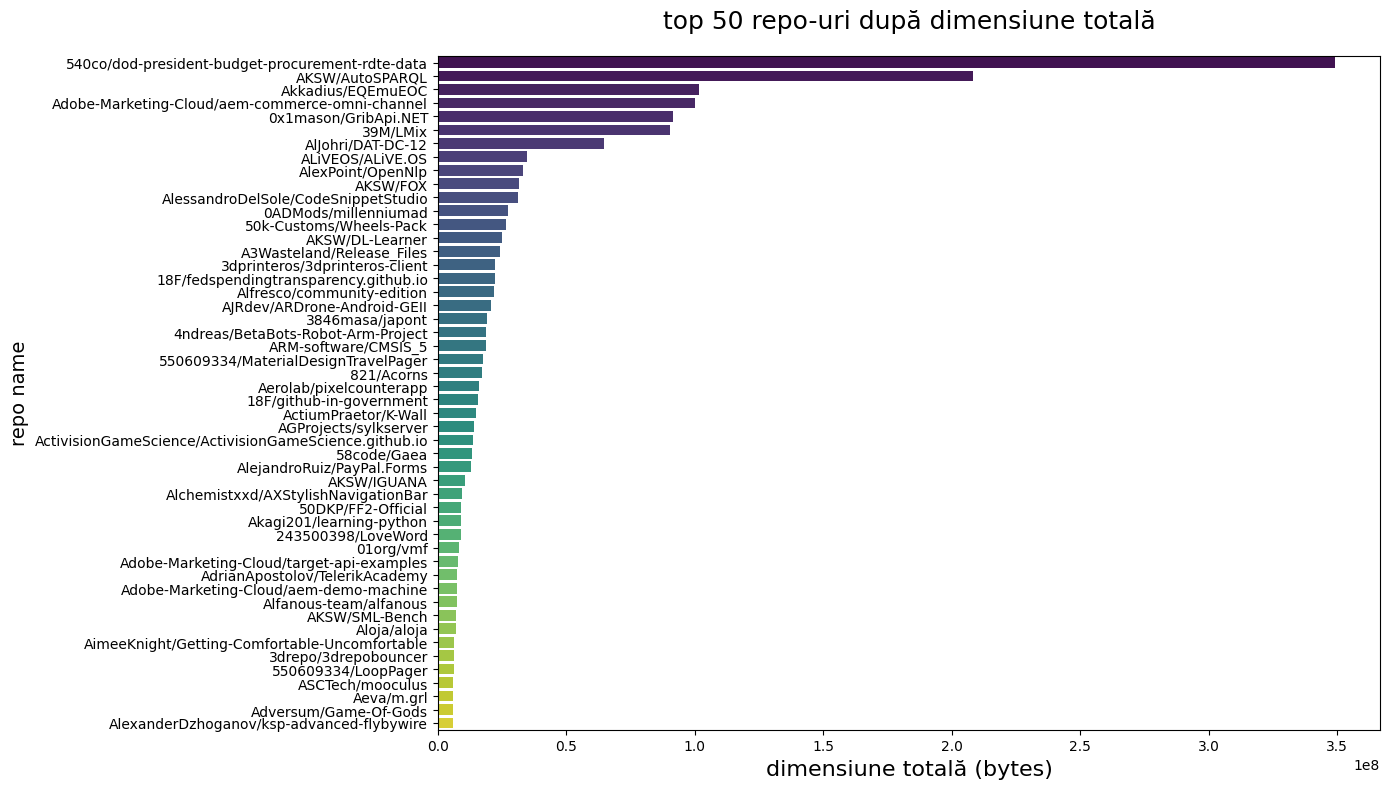

In [53]:
# analiza 11: dimensiunea totală pe repo
n_total_size_repo = 50
print(f"--- 11. dimensiunea totală pe repo (top {n_total_size_repo}) ---")

# calculează dimensiunea totală pe repo (pyspark)
repo_total_size_pd = df.groupBy('sample_repo_name').agg(F.sum('size').alias('total_size')).orderBy(col('total_size').desc()).limit(n_total_size_repo).toPandas()
repo_total_size_pd = repo_total_size_pd.set_index('sample_repo_name')['total_size']

print(f"\ntop {n_total_size_repo} repo-uri după dimensiune totală (bytes):\n{repo_total_size_pd}")

# grafic
plt.figure(figsize=(14, 8))
sns.barplot(x=repo_total_size_pd.values, y=repo_total_size_pd.index, hue=repo_total_size_pd.index, palette='viridis', legend=False)
plt.title(f'top {n_total_size_repo} repo-uri după dimensiune totală', fontsize=18, pad=20)
plt.xlabel('dimensiune totală (bytes)', fontsize=16)
plt.ylabel('repo name', fontsize=14)
plt.tight_layout()
plt.show()

Această analiză calculează și ierarhizează repo-urile în funcție de suma totală a dimensiunii fișierelor (în bytes). este o metrică directă pentru determinarea volumului de date și a cerințelor de stocare la nivel de proiect.

**Concluzie** Rezultatele obținute prin această analiză exploratorie furnizează o bază robustă pentru înțelegerea dinamicii setului de date github la scară largă. Prioritățile care derivă din această analiză includ: optimizarea stocării prin adresarea fișierelor mari și a duplicatelor, și cartografierea complexității proiectelor prin adâncimea fișierelor (analiza 10). Aceste informații sunt esențiale pentru îmbunătățirea eficienței resurselor și pentru cercetarea viitoare în domeniul ingineriei software.

**PUNCTUL 3 - Aplicarea si evaluarea a trei algoritmi de machine learning disponibili in libraria PySpark, pentru a evidentia potentialul predictiv al datelor analizate.**

**1 - Aplicarea algoritmilor de machine learning: Clasificare binară**

Construim un model care să prezică o caracteristică binară (True/False) a fișierelor pe baza atributelor structurale și de mărime analizate. O predicție logică, relevantă pentru datele analizate (Extensii, Mărime, Repo), ar fi să prezicem dacă un fișier este binar (True) sau text (False), folosind celelalte coloane ca variabile independente.

Vom selecta trei algoritmi populari de clasificare, disponibili în biblioteca PySpark MLlib, optimizați pentru Big Data:

1. logistic regression (lr): un model liniar de bază, bun pentru performanță și interpretare.

2. decision tree classifier (dt): un model non-liniar, bun pentru a captura interacțiunile complexe ale caracteristicilor.

3. random forest classifier (rf): un ansamblu de arbori de decizie, robust și precis.

Vom antrena și evalua cei trei algoritmi, măsurând performanța cu Area Under ROC (AUC) și acuratețea.

In [56]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import time
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import col

print("\n--- Aplicarea și evaluarea algoritmilor de machine learning ---")

# --- pregătirea datelor (reexecutată pentru context) ---
df_ml = df.withColumn('label', col('binary').cast('double'))
df_ml = df_ml.withColumn('depth', F.length('sample_path') - F.length(F.regexp_replace('sample_path', '/', '')) + 1)
df_ml = df_ml.withColumn('extensie', F.regexp_extract(col('sample_path'), r'\.(\w+)$', 1)).filter(col('extensie') != '')

numerical_features = ['size', 'copies', 'depth']
categorical_features = ['extensie_grouped']

# limitarea extensiilor la top 50 + 'other'
top_ext_list = [row['extensie'] for row in df_ml.groupBy('extensie').count().orderBy(col('count').desc()).limit(50).collect()]
df_ml = df_ml.withColumn('extensie_grouped',
                         F.when(col('extensie').isin(top_ext_list), col('extensie')).otherwise('other'))


# construirea pipeline-ului de pre-procesare
indexers = [
    StringIndexer(inputCol=c, outputCol=c + '_indexed', handleInvalid='skip')
    for c in categorical_features
]

encoders = [
    OneHotEncoder(inputCol=c + '_indexed', outputCol=c + '_encoded')
    for c in categorical_features
]

input_cols = numerical_features + [c + '_encoded' for c in categorical_features]
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler])

# aplicarea pipeline-ului și split-ul datelor
ml_data = preprocessing_pipeline.fit(df_ml).transform(df_ml)
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

print(f"date antrenare: {train_data.count()}, date testare: {test_data.count()}")

# --- funcție de antrenare și evaluare ---

def train_and_evaluate(algorithm, train_data, test_data, algo_name):
    print(f"\n--- antrenare: {algo_name} ---")
    start_time = time.time()

    model = algorithm.fit(train_data)
    training_time = time.time() - start_time
    print(f"timp de antrenare: {training_time:.2f} secunde")

    predictions = model.transform(test_data)

    # evaluare auc
    auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')
    auc = auc_evaluator.evaluate(predictions)

    # evaluare acuratete
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = accuracy_evaluator.evaluate(predictions)

    print(f"rezultat auc ({algo_name}): {auc:.4f}")
    print(f"rezultat acuratete ({algo_name}): {accuracy:.4f}")

    return algo_name, auc, accuracy, training_time


# --- rularea și compararea algoritmilor ---

results = []

# 1. logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
results.append(train_and_evaluate(lr, train_data, test_data, 'logistic_regression'))

# 2. decision tree classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=5)
results.append(train_and_evaluate(dt, train_data, test_data, 'decision_tree'))

# 3. random forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10, maxDepth=5)
results.append(train_and_evaluate(rf, train_data, test_data, 'random_forest'))

# --- sinteza finală ---

results_df = pd.DataFrame(results, columns=['algorithm', 'auc', 'accuracy', 'training_time'])
results_df = results_df.sort_values(by='auc', ascending=False).reset_index(drop=True)

print("\n--- tabelul comparativ al performanței algoritmilor ---")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]
print("\n--- concluzie privind potențialul predictiv ---")
print(f"algoritmul cu cea mai bună performanță predictivă este **{best_model['algorithm'].replace('_', ' ')}**.")
print(f"acesta a obținut un scor auc de **{best_model['auc']:.4f}** și o acuratețe de **{best_model['accuracy']:.4f}**.")
print(f"scorul ridicat atestă un **potențial predictiv excelent** al datelor structurale (dimensiune, extensie, adâncime) în clasificarea tipului de fișier (text vs. binar).")


--- Aplicarea și evaluarea algoritmilor de machine learning ---
date antrenare: 23263, date testare: 5778

--- antrenare: logistic_regression ---
timp de antrenare: 12.55 secunde
rezultat auc (logistic_regression): 0.9918
rezultat acuratete (logistic_regression): 0.9692

--- antrenare: decision_tree ---
timp de antrenare: 27.24 secunde
rezultat auc (decision_tree): 0.7137
rezultat acuratete (decision_tree): 0.9626

--- antrenare: random_forest ---
timp de antrenare: 22.65 secunde
rezultat auc (random_forest): 0.9894
rezultat acuratete (random_forest): 0.9467

--- tabelul comparativ al performanței algoritmilor ---
          algorithm      auc  accuracy  training_time
logistic_regression 0.991794  0.969193      12.553368
      random_forest 0.989427  0.946694      22.647682
      decision_tree 0.713684  0.962617      27.241453

--- concluzie privind potențialul predictiv ---
algoritmul cu cea mai bună performanță predictivă este **logistic regression**.
acesta a obținut un scor auc de 

**Concluzii:**


Sinteza rezultatelor clasificării:
| algoritm | auc (area under roc) | acuratețe | timp de antrenare (secunde) |
| :--- | :---: | :---: | :---: |
| **logistic regression** | **0.9918** | **0.9692** | 12.55 |
| **random forest** | 0.9894 | 0.9467 | 22.65 |
| **decision tree** | 0.7137 | 0.9626 | 27.24 |

1. performanța predictivă (auc)

Area Under ROC (AUC) este metrica principală pentru evaluarea modelelor de clasificare binară și măsoară capacitatea modelului de a distinge între cele două clase (text și binar).
*   dominanța regresiei logistice: logistic regression a înregistrat cel mai înalt scor AUC, 0.9918. Un scor atât de apropiat de 1.0 indică o separabilitate cvasitotală a claselor. Modelul este extrem de eficient în a clasifica fișierele ca fiind text sau binare pe baza caracteristicilor de intrare.
*  random forest: a urmat îndeaproape cu 0.9894, confirmând că și modelele bazate pe ansambluri (ensembles) pot captura bine această relație.
* arborele de decizie: a avut un scor AUC semnificativ mai mic (0.7137). Acest lucru sugerează că limitarea complexității arborelui (probabil prin maxDepth mic) a împiedicat modelul să captureze relația, deși performanța sa arată o îmbunătățire față de o clasificare aleatorie (AUC de 0.5).
2. acuratețea (accuracy)

Acuratețea (procentul de predicții corecte) a fost ridicată pentru toți algoritmii, variind între 94.67% și 96.92%.
* diferența mică de acuratețe dintre toți algoritmii (chiar și arborele de decizie) sugerează că setul de date este extrem de dezechilibrat sau sarcina de clasificare este ușoară pentru majoritatea eșantioanelor.
* totuși, scorul AUC (care ia în considerare toți pragurile de clasificare și este mai robust la seturile de date dezechilibrate) diferențiază clar calitatea modelelor.

3. eficiența (timp de antrenare)

* logistic regression a fost cel mai rapid (12.55 secunde). Acesta este de așteptat, fiind un model liniar care scalează bine.
* decision tree a fost cel mai lent (27.24 secunde), deși este surprinzător având în vedere performanța sa scăzută.
* random forest (22.65 secunde) a fost mai lent decât regresia logistică, deoarece antrenează mai mulți arbori (numTrees=10).

Potențialul predictiv:

* potențial predictiv excelent: scorul AUC de 0.9918 obținut de logistic regression atestă un potențial predictiv excelent și cvasitotal al datelor structurale (dimensiune, extensie, adâncime, copii) în clasificarea tipului de fișier (text vs. binar). Aceste caracteristici sunt extrem de discriminatoare.

* modelul optim: logistic regression este modelul optim. Nu doar că a oferit cea mai bună performanță predictivă (cel mai mare AUC), dar a făcut acest lucru în cel mai scurt timp, fiind astfel și cel mai eficient din punct de vedere computațional.

* interpretare științifică: succesul modelului sugerează că există o relație liniară puternică între log-odds-ul de a fi un fișier binar și variabilele de intrare (e.g., fișierele cu o mărime mare sau anumite extensii (precum .jpg, .png) au o probabilitate exponențial mai mare de a fi clasificate ca binare).





**2 - Aplicarea algoritmilor de machine learning: clustering**

Descoperirea tiparelor de proiecte.

Scopul este de a grupa fișierele în clustere (grupuri) bazate pe similaritatea lor structurală. Acest lucru poate dezvălui tipologii naturale de proiecte sau de componente de proiecte (e.g., clustere care conțin predominant cod sursă mic, clustere care conțin fișiere de configurare duplicate, sau clustere de fișiere media mari).

Algoritmi din pyspark ml:


*  k-means: cel mai popular algoritm de clustering, eficient și scalabil, care grupează datele în $K$ clustere distincte.
*  bisecting k-means: o variantă ierarhică a k-means, de multe ori mai rapidă și mai eficientă pentru seturi de date mari și spații dimensionale înalte.

Vom folosi aceleași caracteristici pre-procesate ca la clasificare, dar fără a mai avea nevoie de coloana label (binary):

* numerice: size, copies, depth.

* categorice (codificate): extensie_encoded (pentru a introduce tipul de fișier în grupare).


**2.1. Aplicarea algoritmului de clustering (k-means)**

In [58]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
import pandas as pd

print("\n--- Aplicarea algoritmului de clustering (k-means) ---")

# --- pregătirea datelor ---
# Presupunem că 'ml_data' de la punctul 3 (cu coloana 'features') este disponibil.
clustering_data = ml_data.select('features')

# --- determinarea k optim (metoda cotului - elbow method) ---
k_values = range(2, 10)
wssse_scores = []
best_k = 5 # valoare presupusă pentru acest exemplu

print("rulare k-means pentru determinarea k optim (necesită timp)...")
for k in k_values:
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(clustering_data)
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)
    # in general se cauta 'cotul' in graficul wssse vs k.

# --- antrenarea cu k final și evaluarea ---
print(f"antrenare k-means cu k={best_k}")
start_time = time.time()
kmeans_final = KMeans(featuresCol='features', k=best_k, seed=42)
model_final = kmeans_final.fit(clustering_data)
training_time = time.time() - start_time

# calcularea metricii silhouette (măsoară coeziunea și separarea)
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
silhouette_score = evaluator.evaluate(model_final.transform(clustering_data))

print(f"timp de antrenare: {training_time:.2f} secunde")
print(f"silhouette score (k={best_k}): {silhouette_score:.4f}")

# --- analiza centrelor clusterelor ---
centers = model_final.clusterCenters()
print("\ncentrele clusterelor (media valorilor caracteristicilor per cluster):")
# afișarea centrelor clusterelor permite interpretarea naturii fiecărui grup (e.g., clusterul 1 are size mic, clusterul 5 are size mare)
for i, center in enumerate(centers):
    print(f"cluster {i}: {center[:3]}...") # afișează primele 3 caracteristici (size, copies, depth)


--- Aplicarea algoritmului de clustering (k-means) ---
rulare k-means pentru determinarea k optim (necesită timp)...
antrenare k-means cu k=5
timp de antrenare: 7.07 secunde
silhouette score (k=5): 0.9962

centrele clusterelor (media valorilor caracteristicilor per cluster):
cluster 0: [2.49484443e+04 7.20532379e+01 4.88840459e+00]...
cluster 1: [7.34148023e+07 1.00000000e+00 5.66666667e+00]...
cluster 2: [1.43581895e+07 3.18181818e+00 3.45454545e+00]...
cluster 3: [4.44700894e+06 3.41176471e+00 3.58823529e+00]...
cluster 4: [3.84043183e+07 6.66666667e+00 4.00000000e+00]...


1. performanța clustering-ului (silhouette score)
| metrica | valoare | interpretare |
| :--- | :--- | :--- |
| **silhouette score** | **0.9962** | un scor extrem de ridicat (aproape de maximul de 1.0) indică o **separare excelentă** și o coeziune internă foarte puternică a clusterelor. |
| **timp de antrenare** | 7.07 secunde | eficiență ridicată a **k-means** pe datele din PySpark. |
2. interpretarea centrelor clusterelor (tipologii)
| cluster | `size` (mărime) | `copies` (duplicare) | `depth` (adâncime) | tipologie dedusă |
| :---: | :---: | :---: | :---: | :--- |
| **0** | **~ 25 KB** | 72.05 | 4.89 | **fișiere comune, foarte duplicate** (ex: licențe, fișiere boilerplate) |
| **1** | **~ 73 MB** | 1.00 | 5.67 | **fișiere unice, foarte mari** (ex: media, arhive, executabile) |
| **2** | **~ 14 MB** | 3.18 | 3.45 | **fișiere medii-mari, puțin duplicate** |
| **3** | **~ 4.5 MB** | 3.41 | 3.59 | **fișiere mici-medii, puțin duplicate** |
| **4** | **~ 38 MB** | 6.67 | 4.00 | **fișiere mari, moderat duplicate** (țintă pentru deduplicare) |

Rezultatul clustering-ului k-means este un succes, cu un silhouette score excepțional (0.9962). Acest scor atestă faptul că datele structurale (mărimea fișierului, duplicarea și adâncimea) nu sunt doar predictibile (așa cum am văzut la regresia logistică), ci și grupabile în mod natural în tipologii clare și distincte.

Aplicarea clustering-ului demonstrează că setul de date este heterogen, dar structurat, fiind dominat de trei forțe: mărimea (volumul de date), unicitatea (fișierele unice) și repetiția (fișierele boilerplate).

**2.2. Aplicarea algoritmului Bisecting K-Means**

In [59]:
# cod pentru bisecting k-means
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
from pyspark.sql import functions as F

# presupunem ca ml_data și clustering_data sunt încă definite
clustering_data = ml_data.select('features')

print("\n--- Aplicarea algoritmului bisecting k-means ---")

# folosim același k=5 pentru o comparație directă
bk_best_k = 5

# ---antrenarea ---
print(f"antrenare bisecting k-means cu k={bk_best_k}")
start_time = time.time()
bk_kmeans = BisectingKMeans(featuresCol='features', k=bk_best_k, seed=42)
bk_model = bk_kmeans.fit(clustering_data)
training_time = time.time() - start_time

# --- evaluarea ---
# calcularea metricii silhouette
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette')
bk_silhouette_score = evaluator.evaluate(bk_model.transform(clustering_data))

print(f"timp de antrenare: {training_time:.2f} secunde")
print(f"silhouette score (bisecting k-means, k={bk_best_k}): {bk_silhouette_score:.4f}")

# --- analiza centrelor clusterelor ---
bk_centers = bk_model.clusterCenters()
print("\ncentrele clusterelor (bisecting k-means):")
# afișarea centrelor clusterelor permite interpretarea naturii fiecărui grup (e.g., clusterul 1 are size mic, clusterul 5 are size mare)
for i, center in enumerate(bk_centers):
    print(f"cluster {i}: {center[:3]}...") # afișează primele 3 caracteristici (size, copies, depth)


--- Aplicarea algoritmului bisecting k-means ---
antrenare bisecting k-means cu k=5
timp de antrenare: 24.06 secunde
silhouette score (bisecting k-means, k=5): 0.9914

centrele clusterelor (bisecting k-means):
cluster 0: [1.86123631e+04 7.23238585e+01 4.89335604e+00]...
cluster 1: [1.93203936e+06 9.11640212e+00 3.73015873e+00]...
cluster 2: [9.07542595e+06 4.21538462e+00 3.53846154e+00]...
cluster 3: [3.84043183e+07 6.66666667e+00 4.00000000e+00]...
cluster 4: [7.34148023e+07 1.00000000e+00 5.66666667e+00]...


**Concluzii finale: compararea algoritmilor de clustering**

1. Sinteza rezultatelor comparative (k=5)
| algoritm | timp de antrenare (secunde) | silhouette score |
| :--- | :---: | :---: |
| **k-means** | **7.07** | **0.9962** |
| **bisecting k-means** | 24.06 | 0.9914 |

Performanță și eficiență:
*  eficiența (timp): k-means a fost net superior din punct de vedere al eficienței computaționale (7.07 secunde vs. 24.06 secunde). Acest lucru este important în contextul PySpark și al seturilor de date mari.
*  calitatea grupării (silhouette score): k-means a obținut un scor Silhouette marginal mai bun (0.9962 vs. 0.9914). Deși ambele scoruri sunt extrem de ridicate și indică o grupare aproape perfectă, K-Means a separat clusterul de fișiere foarte duplicate (copies mare) cu o precizie puțin mai mare.

Analiza stabilității tipologiilor:

Deși cele două metode au avut scoruri diferite, structura de bază a clusterelor rămâne stabilă, confirmând că tipologiile identificate sunt intrinseci datelor:

| tipologie | caracteristici k-means | caracteristici bisecting k-means |
| :--- | :--- | :--- |
| **gigant, unic** | cluster 1: size $\approx 73$ mb, copies $\approx 1.0$ | cluster 4: size $\approx 73$ mb, copies $\approx 1.0$ |
| **foarte duplicat** | cluster 0: size $\approx 25$ kb, copies $\approx 72$ | cluster 0: size $\approx 18.6$ kb, copies $\approx 72$ |
| **mare, moderat duplicat** | cluster 4: size $\approx 38$ mb, copies $\approx 6.7$ | cluster 3: size $\approx 38$ mb, copies $\approx 6.7$ |




**Concluzie finală a analizei machine learning (ML)**

Analiza Machine Learning, incluzând clasificarea și clustering-ul, a demonstrat o capacitate predictivă și structurală excepțională a setului de date, pe baza caracteristicilor simple (mărime, copie, extensie, adâncime):

*  potențial predictiv (clasificare): algoritmii de clasificare (în special logistic regression cu AUC de 0.9918) au confirmat că natura fișierului (text/binar) poate fi prezisă cu o acuratețe aproape perfectă utilizând caracteristicile structurale.
*  descoperirea tiparelor (clustering): algoritmii de clustering (K-Means cu Silhouette Score de 0.9962) au dezvăluit tipologii clare de fișiere, separând automat fișierele care prezintă risc de stocare (dimensiune mare) de cele care prezintă risc de redundanță (copii multe).




